In [1]:
%matplotlib inline
%cd ..
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

In [2]:
# define func to calculate enthalpy
from CoolProp.HumidAirProp import HAProps, HAPropsSI

def calc_enth(df: pd.DataFrame) -> pd.Series:
    Tn = 273.15  # absolute temp.
    df_drop = df[["air_temperature", "dew_temperature", "sea_level_pressure"]].dropna()
    # NOTE: unit of temperature and pressure must be [K] and kPa respectively.
    enth = HAPropsSI("H",\
              "T", df_drop["air_temperature"].values + Tn,\
              "D", df_drop["dew_temperature"].values + Tn,\
              "P", df_drop["sea_level_pressure"].values * 10.0
             )
    enth = pd.Series(enth, index=df_drop.index)
    df = df.assign(enth=enth)
    return df["enth"]

In [3]:
# load dataset
DATA_FEATHER = "../data/processed/"
train = pd.read_feather(DATA_FEATHER + "train.ftr")
test = pd.read_feather(DATA_FEATHER + "test.ftr")

In [4]:
weather_train = train.groupby(["site_id", "timestamp"]).mean().reset_index()
weather_test = test.groupby(["site_id", "timestamp"]).mean().reset_index()

In [5]:
%%time
# calculate enthalpy
weather_train["enth"] = calc_enth(weather_train)
weather_test["enth"] = calc_enth(weather_test)

CPU times: user 3min 10s, sys: 316 ms, total: 3min 11s
Wall time: 3min 10s


In [6]:
weather_train[["site_id", "timestamp", "enth"]].head()

,site_id,timestamp,enth
0,0,2016-01-01 00:00:00,497655.543050
1,0,2016-01-01 01:00:00,540447.672002
2,0,2016-01-01 02:00:00,538227.762187
3,0,2016-01-01 03:00:00,515472.548512
4,0,2016-01-01 04:00:00,490701.904346


In [7]:
%%time
train = train.merge(weather_train[["site_id", "timestamp", "enth"]], left_on=["site_id", "timestamp"], right_on=["site_id", "timestamp"])
test = test.merge(weather_test[["site_id", "timestamp", "enth"]], left_on=["site_id", "timestamp"], right_on=["site_id", "timestamp"])

CPU times: user 11.3 s, sys: 2.44 s, total: 13.8 s
Wall time: 13.8 s


## NA value counts ratio by site_id

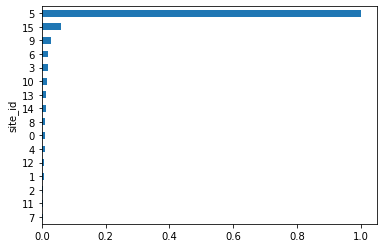

In [8]:
weather_train.groupby("site_id").agg(lambda x: x.isna().sum() / x.size)["enth"].sort_values().plot.barh()

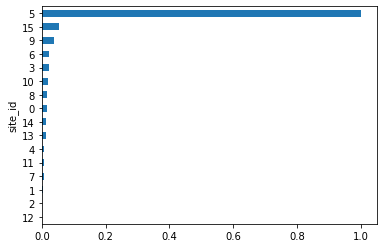

In [9]:
weather_test.groupby("site_id").agg(lambda x: x.isna().sum() / x.size)["enth"].sort_values().plot.barh()

5th site has no enthalpy data

## Plot enthalpy for specified building

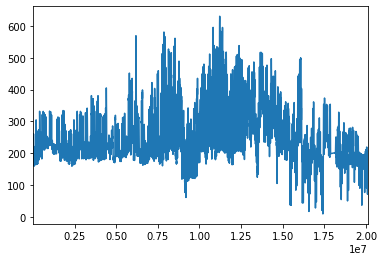

In [10]:
BID = 500
train.query(f"building_id == {BID}")["meter_reading"].plot()

## Plot scatters for specified building

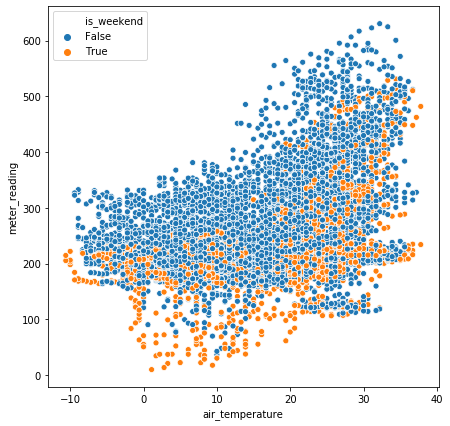

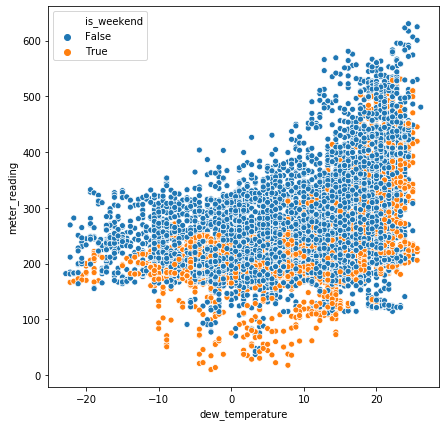

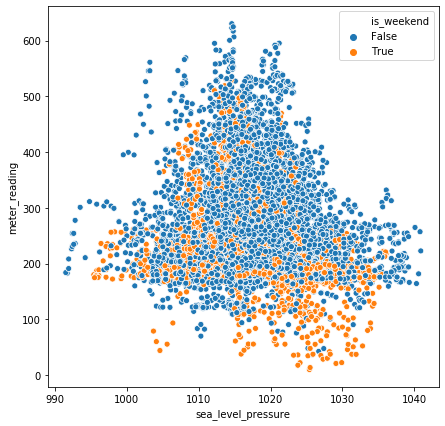

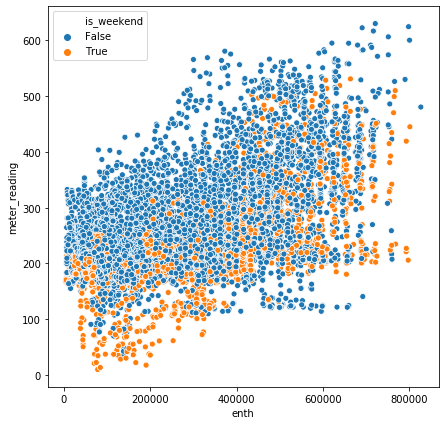

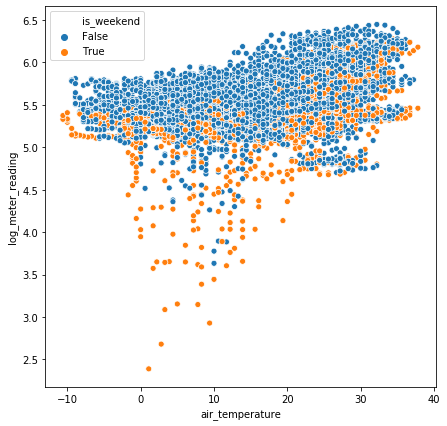

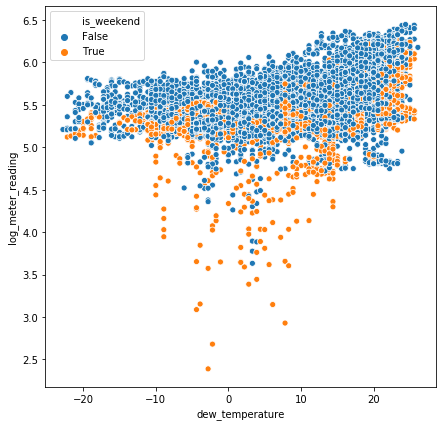

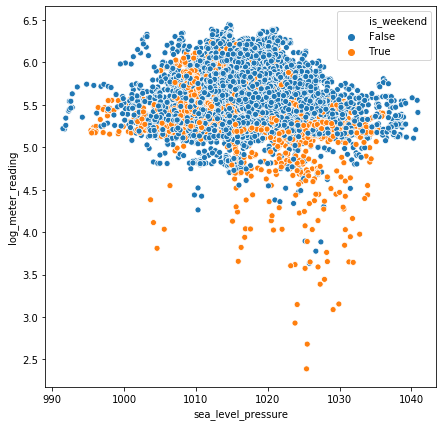

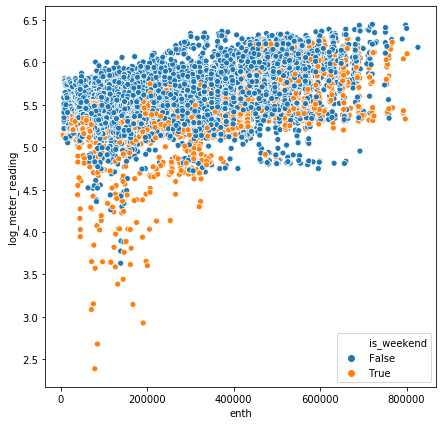

In [11]:
df = train.query(f"building_id == {BID}")[[
    "meter_reading", "log_meter_reading", "air_temperature", "dew_temperature", "sea_level_pressure", "enth", "dayofweek"
]].assign(is_weekend=lambda df: df["dayofweek"].apply(lambda x: True if x in (5,6) else False))
x_feats = ["air_temperature", "dew_temperature", "sea_level_pressure", "enth"]
for x in x_feats:
    f, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=x, y="meter_reading", data=df, hue="is_weekend", ax=ax)
for x in x_feats:
    f, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=x, y="log_meter_reading", data=df, hue="is_weekend", ax=ax)

## Check linear correlation for all buildings

In [18]:
# calculate corr coefs for each building
df = train.groupby("building_id").apply(
    lambda df: df[["air_temperature", "enth", "meter_reading", "log_meter_reading"]].corr()).reset_index()

In [29]:
df.head()

,building_id,level_1,air_temperature,enth,meter_reading,log_meter_reading
0,0,air_temperature,1.000000,0.732439,0.525818,0.468630
1,0,enth,0.732439,1.000000,0.667865,0.590913
2,0,meter_reading,0.525818,0.667865,1.000000,0.968768
3,0,log_meter_reading,0.468630,0.590913,0.968768,1.000000
4,1,air_temperature,1.000000,0.732439,0.554359,0.479346


In [36]:
# convert to long format
df = df.melt(id_vars=["building_id", "level_1"],\
    value_vars=["air_temperature", "enth", "meter_reading", "log_meter_reading"])

In [37]:
df.head()

,building_id,level_1,variable,value
0,0,air_temperature,air_temperature,1.000000
1,0,enth,air_temperature,0.732439
2,0,meter_reading,air_temperature,0.525818
3,0,log_meter_reading,air_temperature,0.468630
4,1,air_temperature,air_temperature,1.000000


In [64]:
# mean by each building
df = df.groupby(["level_1", "variable"]).agg(np.mean).reset_index()\
    .drop(columns="building_id")\
    .pivot(index="level_1", columns="variable")
df.columns.droplevel(0)
df.head()

value                                          
variable          air_temperature      enth log_meter_reading meter_reading
level_1                                                                    
air_temperature          1.000000  0.777685          0.081048      0.078447
enth                     0.777685  1.000000          0.126051      0.137034
log_meter_reading        0.081048  0.126051          1.000000      0.868741
meter_reading            0.078447  0.137034          0.868741      1.000000

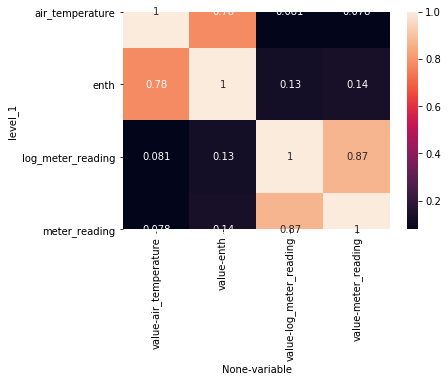

In [71]:
sns.heatmap(df, annot=True)